In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "/kaggle/input/teethdata/Teeth_Dataset"  # Updated dataset path
img_size = (224, 224)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Dataset
train_dataset = ImageFolder(root=os.path.join(data_dir, 'Training'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(data_dir, 'Validation'), transform=transform)
test_dataset = ImageFolder(root=os.path.join(data_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


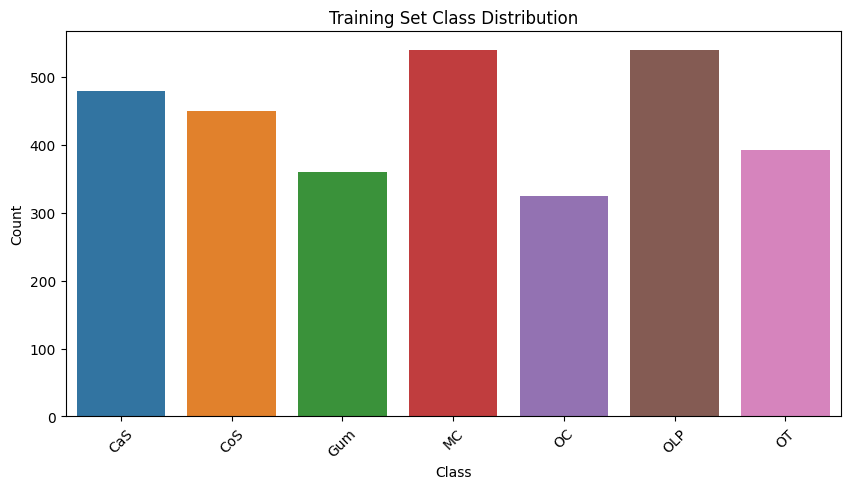

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


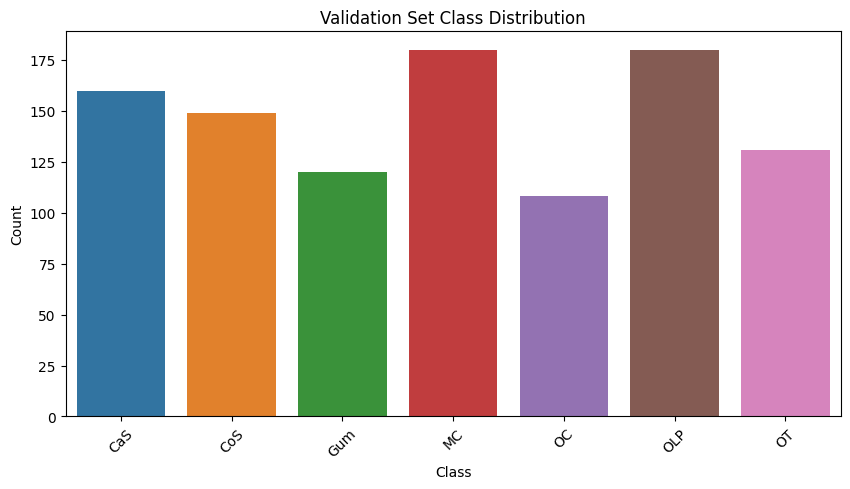

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


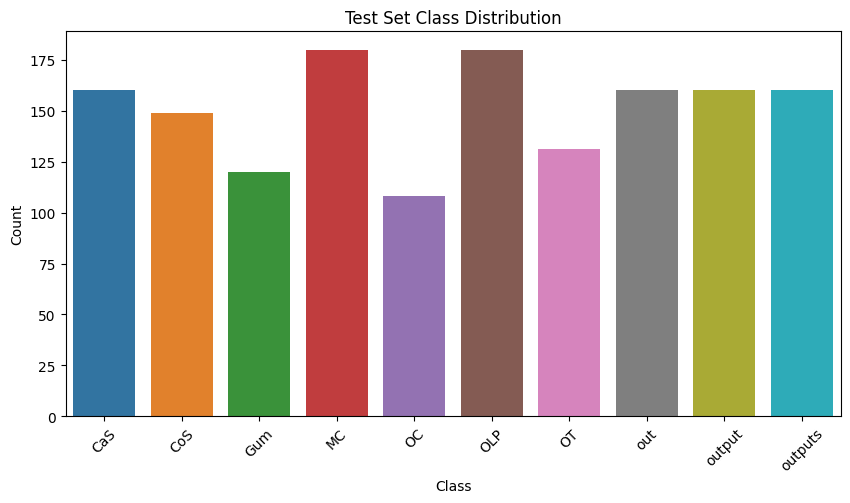

In [6]:
def plot_class_distribution(dataset, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=[cls for cls in dataset.classes], y=[len([x for x in dataset.targets if x == i]) for i in range(len(dataset.classes))])
    plt.xticks(rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(val_dataset, "Validation Set Class Distribution")
plot_class_distribution(test_dataset, "Test Set Class Distribution")

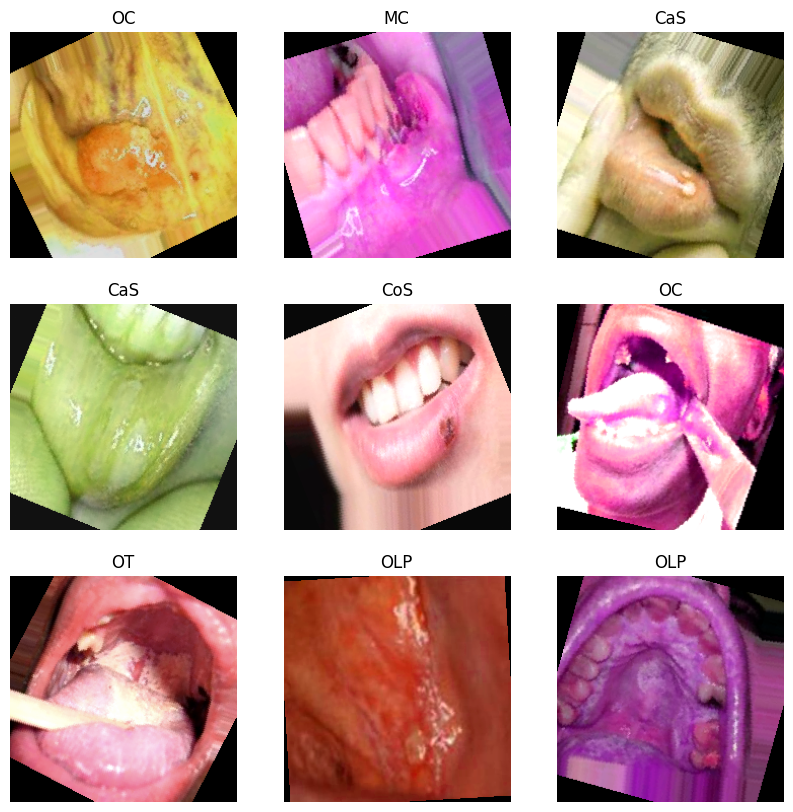

In [5]:
def show_sample_images(loader, dataset):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow((img * 0.5) + 0.5)  # Unnormalize
        ax.set_title(dataset.classes[labels[i]])
        ax.axis("off")
    plt.show()

show_sample_images(train_loader, train_dataset)


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)        

In [5]:
num_classes = len(train_dataset.classes)
print(num_classes)

7


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(running_loss / len(train_loader.dataset))
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_acc:.4f}")
    
    # Plot training performance
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracy")
    plt.show()

Epoch 1/50, Loss: 1.8693, Accuracy: 0.2319
Epoch 2/50, Loss: 1.7624, Accuracy: 0.3022
Epoch 3/50, Loss: 1.6872, Accuracy: 0.3372
Epoch 4/50, Loss: 1.5880, Accuracy: 0.3780
Epoch 5/50, Loss: 1.5239, Accuracy: 0.3997
Epoch 6/50, Loss: 1.4638, Accuracy: 0.4367
Epoch 7/50, Loss: 1.4214, Accuracy: 0.4597
Epoch 8/50, Loss: 1.3711, Accuracy: 0.4820
Epoch 9/50, Loss: 1.3288, Accuracy: 0.4989
Epoch 10/50, Loss: 1.3120, Accuracy: 0.5086
Epoch 11/50, Loss: 1.2581, Accuracy: 0.5326
Epoch 12/50, Loss: 1.2432, Accuracy: 0.5384
Epoch 13/50, Loss: 1.2031, Accuracy: 0.5520
Epoch 14/50, Loss: 1.1673, Accuracy: 0.5675
Epoch 15/50, Loss: 1.1414, Accuracy: 0.5763
Epoch 16/50, Loss: 1.1140, Accuracy: 0.5902
Epoch 17/50, Loss: 1.0810, Accuracy: 0.6054
Epoch 18/50, Loss: 1.0421, Accuracy: 0.6226
Epoch 19/50, Loss: 1.0273, Accuracy: 0.6229
Epoch 20/50, Loss: 0.9723, Accuracy: 0.6485
Epoch 21/50, Loss: 0.9808, Accuracy: 0.6456
Epoch 22/50, Loss: 0.9341, Accuracy: 0.6592
Epoch 23/50, Loss: 0.9212, Accuracy: 0.66

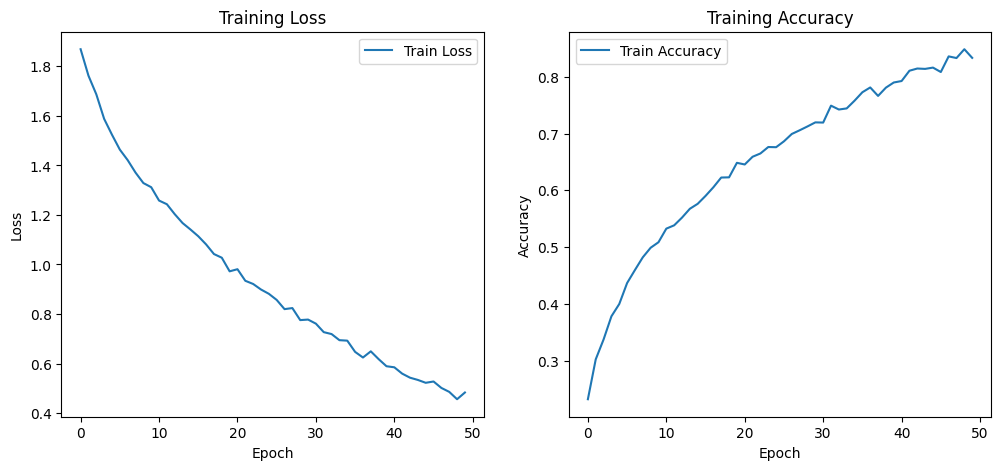

In [8]:
train_model(model, train_loader, val_loader, criterion, optimizer)

# Save Model
torch.save(model.state_dict(), "teeth_classification_model.pth")


In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the saved model
num_classes = 7  # Adjust based on your project
model = CNN(num_classes)  # Initialize the model architecture
model.load_state_dict(torch.load("/kaggle/input/teethmodel/pytorch/default/1/teeth_classification_model.pth", map_location=device))
model.eval()  # Set the model to evaluation mode

# Preprocessing for new images
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# Function to make predictions
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Load image
    image = transform(image).unsqueeze(0)  # Apply transforms and add batch dimension
    with torch.no_grad():  # No gradient calculation needed
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get the class index with the highest score
    return train_dataset.classes[predicted.item()]  # Map index to class name

# Example usage
image_path = "/kaggle/input/teethdata/Teeth_Dataset/Testing/CaS/a_100.jpg"
predicted_class = predict_image(image_path)
print(f"Predicted Class: {predicted_class}")


<ipython-input-8-959273150ee4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/teethmodel/pytorch/default/1/teeth_classific

Predicted Class: CaS


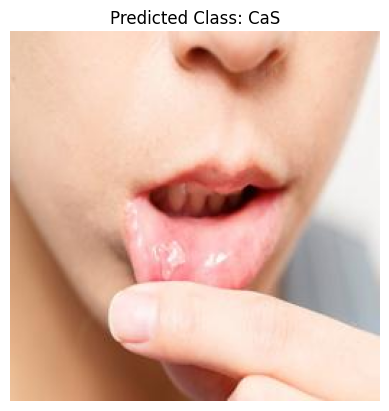

In [9]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()
